In [1]:
import yfinance as yf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

plt.style.use('fivethirtyeight')

In [2]:
tickers = ['IBM', 'GOOG', 'AMZN', ]

In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days=365*2)
start_date

datetime.datetime(2021, 11, 27, 15, 19, 9, 165339)

In [4]:
close_df = pd.DataFrame()

In [5]:
for ticker in tickers:
    data= yf.download(ticker, start=start_date, end=end_date)
    close_df[ticker] = data['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
close_df.head()

,IBM,GOOG,AMZN
Date,,,
2021-11-29,118.500000,146.113998,178.078506
2021-11-30,117.099998,142.451996,175.353500
2021-12-01,116.919998,141.617996,172.186005
2021-12-02,116.900002,143.776505,171.867996
2021-12-03,118.839996,142.520493,169.489502


In [7]:
returns = close_df.pct_change()
returns.head()

,IBM,GOOG,AMZN
Date,,,
2021-11-29,NaN,NaN,NaN
2021-11-30,-0.011814,-0.025063,-0.015302
2021-12-01,-0.001537,-0.005855,-0.018063
2021-12-02,-0.000171,0.015242,-0.001847
2021-12-03,0.016595,-0.008736,-0.013839


In [8]:
means = returns.mean()
means

IBM     0.000624
GOOG    0.000131
AMZN   -0.000026
dtype: float64

In [9]:
variances = returns.var()
variances

IBM     0.000171
GOOG    0.000483
AMZN    0.000724
dtype: float64

In [10]:
cov_matrix = returns.cov()
cov_matrix

,IBM,GOOG,AMZN
IBM,0.000171,0.000085,0.000090
GOOG,0.000085,0.000483,0.000407
AMZN,0.000090,0.000407,0.000724


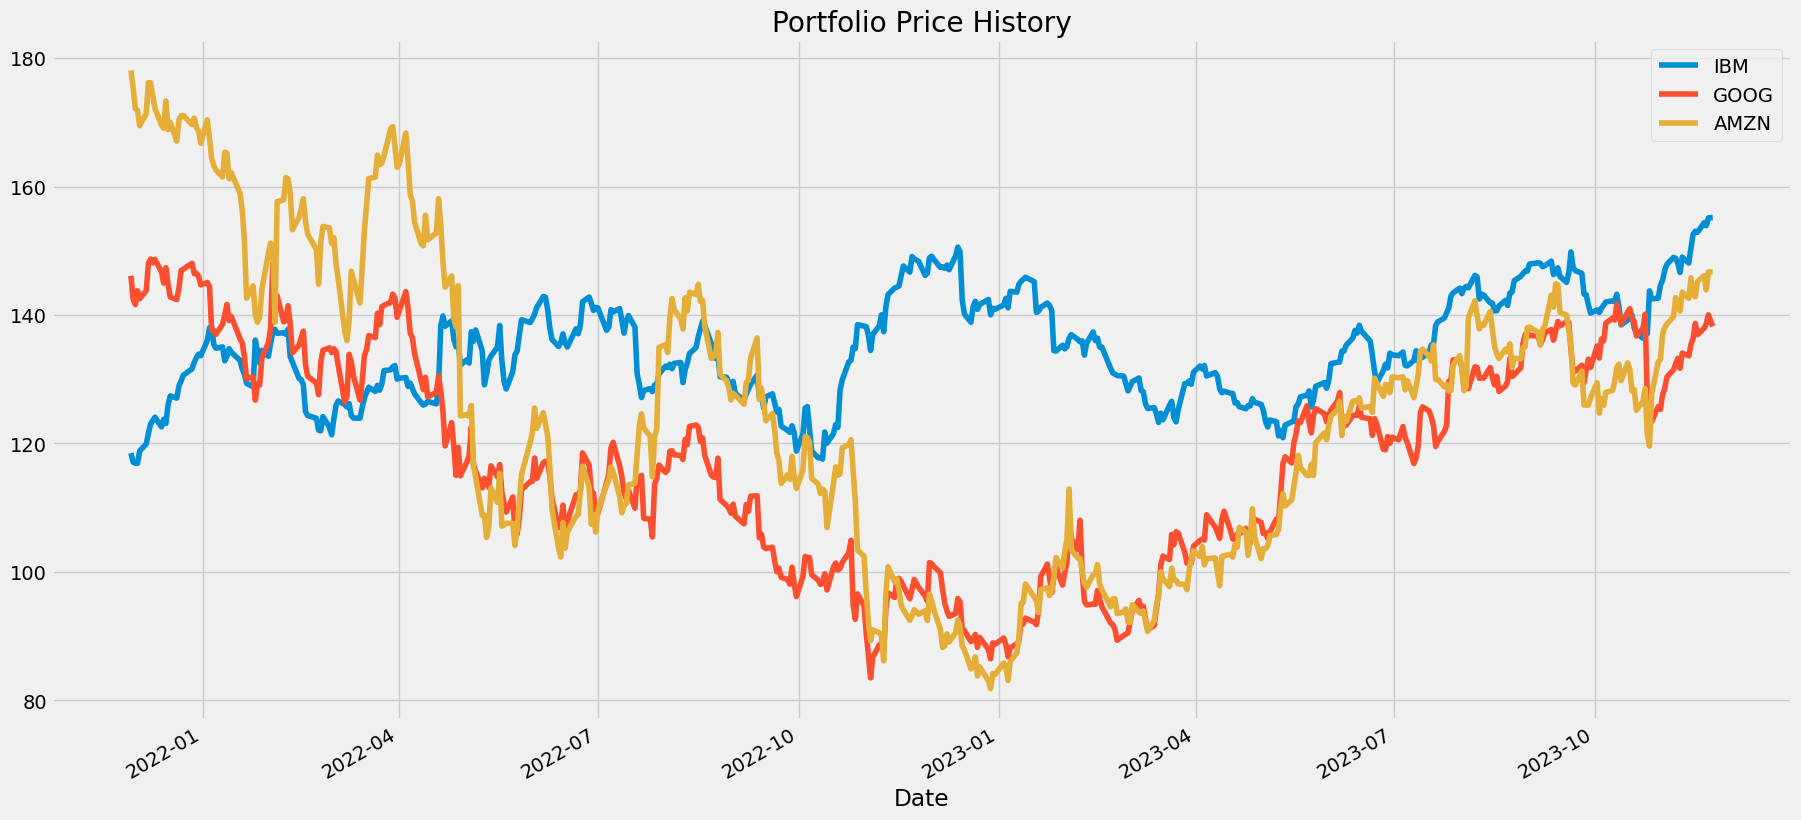

In [11]:
title = 'Portfolio Price History'
stocks = close_df
stocks.plot(title=title, figsize=(20,10))
plt.show()

In [12]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = means
S = cov_matrix
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))

# ef.efficient_return(target_return=0.001, market_neutral=True)
ef.min_volatility()

OrderedDict([('IBM', 0.8185695893274383),
             ('GOOG', 0.1581415112447296),
             ('AMZN', 0.0232888994278321)])

In [13]:
ef.portfolio_performance(verbose=True)

Expected annual return: 0.1%
Annual volatility: 1.2%
Sharpe Ratio: -1.56


(0.0005312300570589015, 0.012454096818361607, -1.563242218756278)

In [14]:
def random_weights(n):
    k = np.random.rand(n)
    return k / sum(k)

weights = random_weights(len(tickers))
weights

array([0.10972439, 0.11121377, 0.77906185])

In [15]:
weights.sum()

1.0

In [16]:
def portfolio_return(weights):
    return np.sum(means * weights)

def portfolio_volatility(weights):
    # use covariance matrix
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


In [17]:
portfolio_return(weights)*100, portfolio_volatility(weights)

(0.006268195216363307, 0.02313454088781053)

In [18]:
def portfolio_annual_return(weights):
    return portfolio_return(weights) * 252
portfolio_annual_return(weights)

0.015795851945235535

In [19]:
# print returns and volatility in a readable format in percent
def print_portfolio(weights):
    print("Expected annual return: {:.1f}%".format(portfolio_annual_return(weights) * 100))
    print('Annual volatility: {:.1f}%'.format(portfolio_volatility(weights) * 100))

print_portfolio(weights)

Expected annual return: 1.6%
Annual volatility: 2.3%


In [20]:
# efficient frontier
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = means
S = cov_matrix
ef_ = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef_.min_volatility()

OrderedDict([('IBM', 0.8185695893274383),
             ('GOOG', 0.1581415112447296),
             ('AMZN', 0.0232888994278321)])

In [21]:
ef_.portfolio_performance(verbose=True)

Expected annual return: 0.1%
Annual volatility: 1.2%
Sharpe Ratio: -1.56


(0.0005312300570589015, 0.012454096818361607, -1.563242218756278)

In [22]:
ef__= EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef__.min_volatility()

OrderedDict([('IBM', 0.8185695893274383),
             ('GOOG', 0.1581415112447296),
             ('AMZN', 0.0232888994278321)])

In [23]:
ef__.portfolio_performance(verbose=True)

Expected annual return: 0.1%
Annual volatility: 1.2%
Sharpe Ratio: -1.56


(0.0005312300570589015, 0.012454096818361607, -1.563242218756278)

In [24]:
ef__.clean_weights()

OrderedDict([('IBM', 0.81857), ('GOOG', 0.15814), ('AMZN', 0.02329)])

In [25]:
ef__.portfolio_performance(verbose=True)

Expected annual return: 0.1%
Annual volatility: 1.2%
Sharpe Ratio: -1.56


(0.0005312300570589015, 0.012454096818361607, -1.563242218756278)

In [26]:
ef___ = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef___.max_sharpe(risk_free_rate=0.0001)

OrderedDict([('IBM', 1.0), ('GOOG', 0.0), ('AMZN', 0.0)])

In [27]:
import cvxpy as cp

weightscp= cp.Variable(len(means))
weightscp

Variable((3,), var216)

In [28]:
objective = cp.Minimize(cp.quad_form(weightscp, cov_matrix.values))

In [29]:
constraints = [weightscp >= 0, weightscp <= 1, cp.sum(weightscp) == 1]

In [30]:
problem = cp.Problem(objective, constraints)

In [31]:
problem.solve()

0.0001551045275611247

In [32]:
weightscp.value

array([0.81856959, 0.15814151, 0.0232889 ])

In [33]:
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("API_KEY")

In [34]:
from fredapi import Fred
fred=Fred(api_key=api_key)
rate=fred.get_series_latest_release('GS10')/100
rf=rate.iloc[-1]
rf

0.048

In [35]:
sharpe_ratio = (portfolio_annual_return(weights) - rf) / portfolio_volatility(weights)
sharpe_ratio

-1.3920374824353081

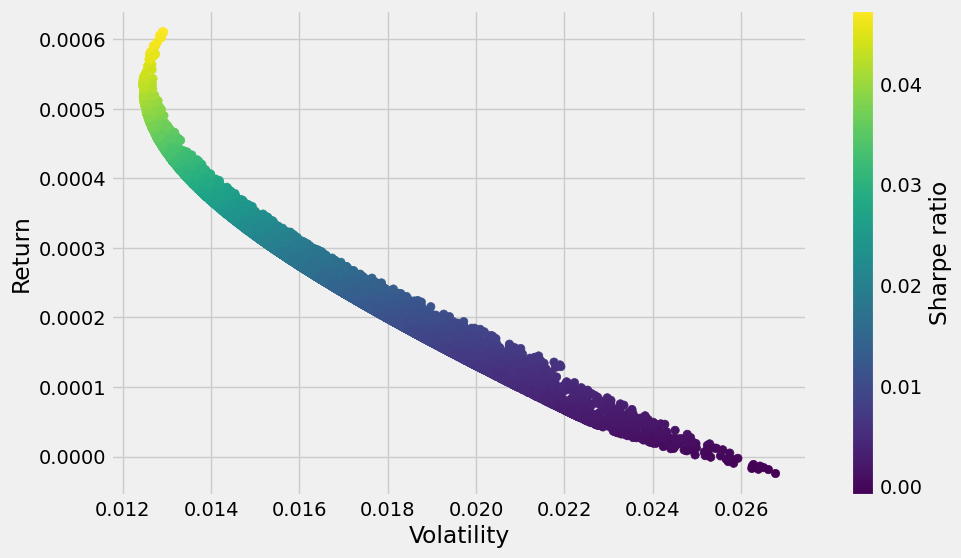

In [39]:
num_portfolios = 10000
portfolio_returns = []
portfolio_volatilities = []

for portfolio in range(num_portfolios):
    weights = random_weights(len(tickers))
    portfolio_returns.append(portfolio_return(weights))
    portfolio_volatilities.append(portfolio_volatility(weights))

portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatilities, portfolio_returns, c=portfolio_returns / portfolio_volatilities, marker='o')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe ratio')
plt.show()